In [29]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from datetime import datetime

In [61]:
gasData = pd.read_csv("Nat_Gas.csv")
format_string = "%m/%d/%y"
gasData['Dates'] = gasData['Dates'].apply(lambda x: datetime.strptime(x, format_string))

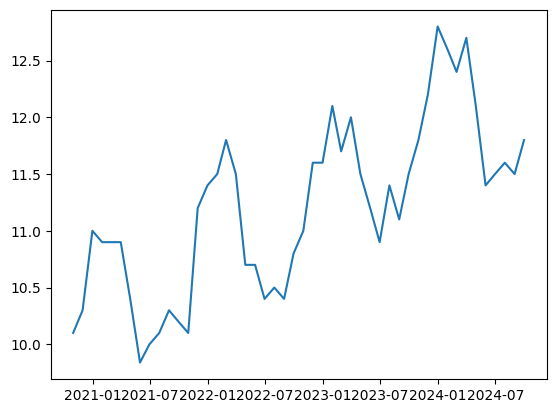

In [62]:
plt.plot(gasData.Dates, gasData.Prices)

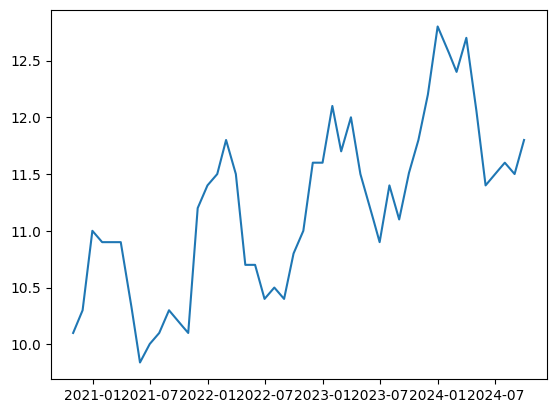

In [64]:
gasData.set_index('Dates', inplace=True)
interpolatedPrice = gasData.Prices.resample('D').interpolate(method='linear')

gasData.reset_index(inplace=True)
interpolatedDates = pd.date_range(start=gasData.Dates.iloc[0],end=gasData.Dates.iloc[-1], freq='D')

interpolatedData = pd.DataFrame({
    "Date" : interpolatedDates,
    "Prices" : interpolatedPrice
})

interpolatedData
plt.plot(interpolatedData.Date, interpolatedData.Prices)


In [86]:
ar_model = sm.tsa.AutoReg(interpolatedData["Prices"], lags=300)
ar_result = ar_model.fit() 
endDate = len(interpolatedData)
forecast = ar_result.predict(start = endDate + 1, end = endDate + 365)

In [87]:
start_date = interpolatedData[-1:].Date.iloc[0] + pd.DateOffset(days=1)
endDate = start_date + pd.DateOffset(days=364)
nextYearDates = pd.date_range(start=start_date,end=endDate, freq='D')

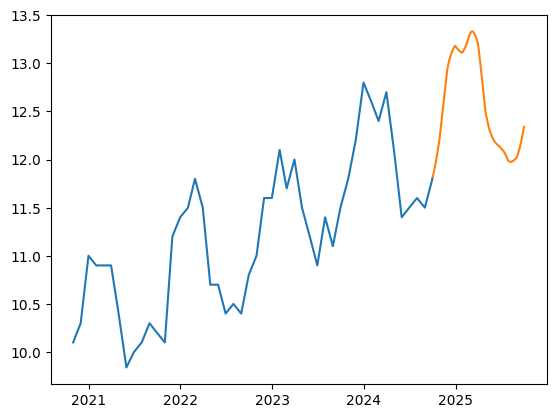

In [88]:
plt.plot(gasData.Dates, gasData.Prices)
plt.plot(nextYearDates, forecast)
plt.plot([interpolatedData.Date.iloc[-1], nextYearDates[0]], [interpolatedData.Prices.iloc[-1], forecast.iloc[0]], color='gray', linestyle='--')

plt.show()

In [90]:
predictionData = pd.DataFrame({
    "Date" : nextYearDates,
    "Prices" : forecast
})

In [103]:
predictionData['Date'] = pd.to_datetime(predictionData['Date'])
predictionData[predictionData.Date == "2025-01-10"]

,Date,Prices
2025-01-11,2025-01-10,13.143806


In [163]:
InjectionWithdrawalData = pd.DataFrame({
    "injectionDate": ["2025-01-10", "2025-03-10"],
    "WithdrawalDate": ["2025-05-10", "2025-06-10"],
    "injectionSize": [50000, 30000],  # in MMBtu
    "WithdrawalSize": [30000, 50000],  # in MMBtu 
})

maxStorage = 10000000
storageCost = 0.02 # $ per MMBtu per day
currentStorageLevel = 0
expenses = 0
remainingSize = 0
value = 0

In [164]:
InjectionWithdrawalData['injectionDate'] = pd.to_datetime(InjectionWithdrawalData['injectionDate'])
InjectionWithdrawalData['WithdrawalDate'] = pd.to_datetime(InjectionWithdrawalData['WithdrawalDate'])
InjectionWithdrawalData

,injectionDate,WithdrawalDate,injectionSize,WithdrawalSize
0,2025-01-10,2025-05-10,50000,30000
1,2025-03-10,2025-06-10,30000,50000


In [183]:
def ValueEstimation(InjectionWithdrawalData):
    global currentStorageLevel 
    global expenses
    global remainingSize
    global value
    for index, quote in InjectionWithdrawalData.iterrows():
        currentStorageLevel += quote["injectionSize"]
        injectionPrice = predictionData[predictionData.Date == quote["injectionDate"]].Prices.iloc[0]
        withdrawalPrice = predictionData[predictionData.Date == quote["WithdrawalDate"]].Prices.iloc[0]
        numDays = (quote["WithdrawalDate"] - quote["injectionDate"]).days
        if(currentStorageLevel > maxStorage):
            print("Storage limit reached for injecttion date: ", quote["injectionDate"])
        else:
            expenses += (storageCost * numDays) * (quote["injectionSize"] + remainingSize)
            remainingSize += quote["injectionSize"] - quote["WithdrawalSize"]
            value += ((injectionPrice - withdrawalPrice)*1000000) - expenses
            currentStorageLevel += remainingSize
    print("Final Value: ", value/1000000)
    currentStorageLevel = 0
    expenses = 0
    remainingSize = 0
    value = 0

In [184]:
ValueEstimation(InjectionWithdrawalData)

Final Value:  1.6083348503939294
